In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.etoile_ventes_avis import graphe_etoile_ventes_avis
import seaborn as sns
DATA_PATH = "../donnees/ecommerce/"

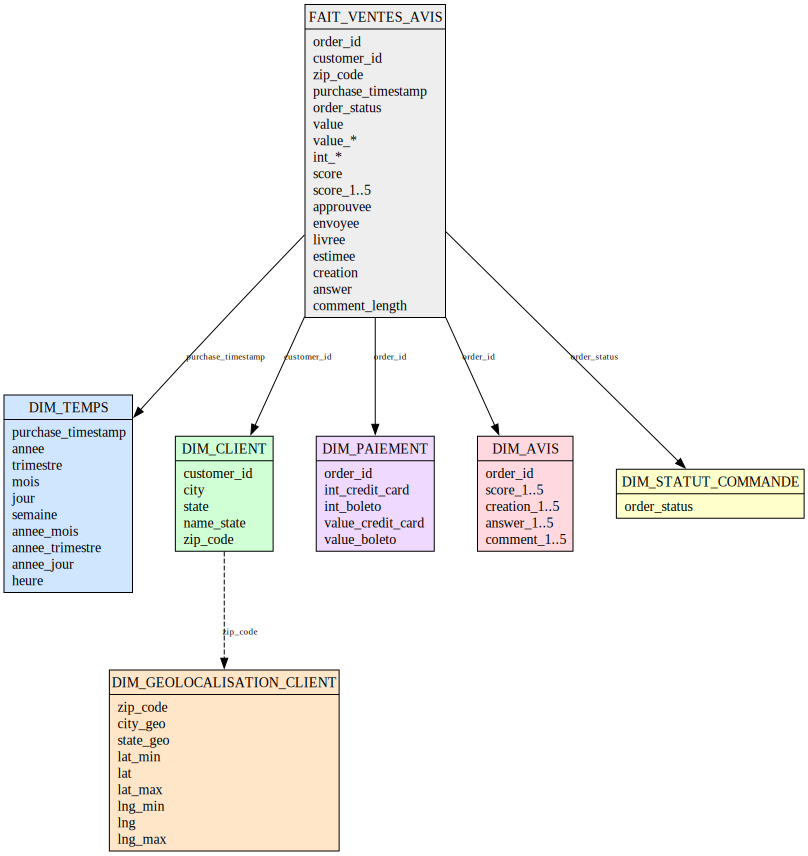

In [44]:
dot_ventes = graphe_etoile_ventes_avis()
dot_ventes

In [45]:
orders    = pd.read_parquet(DATA_PATH + "orders.parquet")
payments  = pd.read_parquet(DATA_PATH + "payments.parquet")
reviews   = pd.read_parquet(DATA_PATH + "reviews.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")
geo       = pd.read_parquet(DATA_PATH + "geolocation.parquet")

In [46]:
print("Shapes brutes :")
print("orders   :", orders.shape)
print("payments :", payments.shape)
print("reviews  :", reviews.shape)
print("customers:", customers.shape)
print("geo      :", geo.shape)

Shapes brutes :
orders   : (99441, 23)
payments : (103886, 5)
reviews  : (98673, 25)
customers: (99441, 6)
geo      : (19015, 9)


In [47]:
# 1) Préparation des paiements (pivot par type de paiement)
pay = payments.rename(columns=lambda c: c.replace("payment_", ""))

pay_pivot = (
    pay
    .pivot_table(
        index="order_id",
        columns="type",
        values=["installments", "value"],
        aggfunc={"installments": "max", "value": "sum"}
    )
)

pay_pivot.columns = [f"{k}_{t}" for (k, t) in pay_pivot.columns]
pay_pivot = pay_pivot.rename(columns=lambda c: c.replace("installments_", "int_"))

value_cols = [c for c in pay_pivot.columns if c.startswith("value_")]
pay_pivot["value"] = pay_pivot[value_cols].sum(axis=1)

pay_pivot = pay_pivot.reset_index()


# 2) Préparation des avis (colonnes score, délais, longueur commentaire)
rev = reviews.copy()

base_cols = ["order_id"]
for c in ["score", "creation", "answer", "comment"]:
    if c in rev.columns:
        base_cols.append(c)

detail_cols = [
    c for c in rev.columns
    if (
        c.startswith("score_")
        or c.startswith("creation_")
        or c.startswith("answer_")
        or (c.startswith("comment_") and c != "comment")
    )
]

cols_reviews = list(dict.fromkeys(base_cols + detail_cols))

reviews_dim = rev[cols_reviews].copy()
if "comment" in reviews_dim.columns:
    reviews_dim = reviews_dim.rename(columns={"comment": "comment_length"})


# 3) Préparation des infos client (clé client + zip_code)
cust_fact = customers[["customer_id", "zip_code"]].copy()


# 3bis) Correction des durées dans orders (en mémoire)
orders = orders.copy()

delta_approuvee = orders["approved_at"] - orders["purchase_timestamp"]
delta_envoyee   = orders["delivered_carrier"] - orders["purchase_timestamp"]
delta_livree    = orders["delivered_customer"] - orders["purchase_timestamp"]
delta_estimee   = orders["estimated_delivery"] - orders["purchase_timestamp"]

orders["approuvee"] = delta_approuvee.dt.total_seconds() / 3600
orders["envoyee"]   = delta_envoyee.dt.total_seconds() / 3600
orders["livree"]    = delta_livree.dt.total_seconds() / 3600
orders["estimee"]   = delta_estimee.dt.total_seconds() / 3600


# 4) Construction de la table de faits F_VENTES_AVIS (jointures)
fact_orders_cols = [
    "order_id",
    "customer_id",
    "purchase_timestamp",
    "order_status",
    "approuvee",
    "envoyee",
    "livree",
    "estimee",
]
fact_orders_cols = [c for c in fact_orders_cols if c in orders.columns]

fact_orders = orders[fact_orders_cols].copy()

F_VENTES_AVIS = (
    fact_orders
    .merge(cust_fact,   on="customer_id", how="left")
    .merge(pay_pivot,   on="order_id",   how="left")
    .merge(reviews_dim, on="order_id",   how="left")
)

cols_schema = [
    "order_id",
    "customer_id",
    "zip_code",
    "purchase_timestamp",
    "order_status",
    "value",
    "approuvee",
    "envoyee",
    "livree",
    "estimee",
    "score",
    "creation",
    "answer",
    "comment_length",
]

extra_cols = [
    c for c in F_VENTES_AVIS.columns
    if c.startswith("value_")
    or c.startswith("int_")
    or c.startswith("score_")
    or c.startswith("creation_")
    or c.startswith("answer_")
    or (c.startswith("comment_") and c != "comment_length")
]

final_cols = [c for c in cols_schema + extra_cols if c in F_VENTES_AVIS.columns]
F_VENTES_AVIS = F_VENTES_AVIS[final_cols]


# 5) Contrôle rapide du résultat
print("F_VENTES_AVIS shape :", F_VENTES_AVIS.shape)
print("Colonnes (", len(F_VENTES_AVIS.columns), "):")
print(list(F_VENTES_AVIS.columns))

display(F_VENTES_AVIS.head(5))


# 6) Sauvegarde en Parquet pour les autres analyses
OUTPUT_PATH = "f_ventes_avis.parquet"

F_VENTES_AVIS.to_parquet(OUTPUT_PATH, index=False)
print(f"F_VENTES_AVIS sauvegardé dans : {OUTPUT_PATH}")


F_VENTES_AVIS shape : (99441, 43)
Colonnes ( 43 ):
['order_id', 'customer_id', 'zip_code', 'purchase_timestamp', 'value', 'approuvee', 'envoyee', 'livree', 'estimee', 'score', 'creation', 'answer', 'comment_length', 'int_boleto', 'int_credit_card', 'int_debit_card', 'int_not_defined', 'int_voucher', 'value_boleto', 'value_credit_card', 'value_debit_card', 'value_not_defined', 'value_voucher', 'answer_1', 'answer_2', 'answer_3', 'answer_4', 'answer_5', 'comment_1', 'comment_2', 'comment_3', 'comment_4', 'comment_5', 'creation_1', 'creation_2', 'creation_3', 'creation_4', 'creation_5', 'score_1', 'score_2', 'score_3', 'score_4', 'score_5']


,order_id,customer_id,zip_code,purchase_timestamp,value,approuvee,envoyee,livree,estimee,score,...,creation_1,creation_2,creation_3,creation_4,creation_5,score_1,score_2,score_3,score_4,score_5
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3149,2017-10-02 10:56:33,38.71,0.178333,56.974167,202.477778,373.057500,4.0,...,0.0,0.0,0.0,205.0,0.0,0.0,0.0,0.0,1.0,0.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,47813,2018-07-24 20:41:37,141.46,30.713889,41.823056,330.768889,459.306389,4.0,...,0.0,0.0,0.0,339.0,0.0,0.0,0.0,0.0,1.0,0.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,75265,2018-08-08 08:38:49,179.12,0.276111,5.186389,225.461111,639.353056,5.0,...,0.0,0.0,0.0,0.0,231.0,0.0,0.0,0.0,0.0,1.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,59296,2017-11-18 19:28:06,72.20,0.298056,90.198056,317.010000,628.531667,5.0,...,0.0,0.0,0.0,0.0,340.0,0.0,0.0,0.0,0.0,1.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,9195,2018-02-13 21:18:39,28.62,1.030556,22.465278,68.973056,290.689167,5.0,...,0.0,0.0,0.0,0.0,74.0,0.0,0.0,0.0,0.0,1.0


F_VENTES_AVIS sauvegardé dans : f_ventes_avis.parquet


In [48]:
# Analyse 1 : Performance commerciale & saisonnalité vs satisfaction
# Dans cette première analyse, je veux comprendre la dynamique globale du business :
# comment évoluent les ventes dans le temps (année, trimestre, mois) et comment cela
# se connecte à la satisfaction client (score moyen des avis). C’est la vue d’ensemble
# indispensable avant d’entrer dans le détail opérationnel : je pars du CA total et du
# volume de commandes, puis je descends dans les hiérarchies de temps et de géographie
# pour identifier les saisons fortes, les périodes faibles et les zones clés.

In [49]:
# Préparation
fva = F_VENTES_AVIS.copy()
fva["year"] = fva["purchase_timestamp"].dt.year
fva["month"] = fva["purchase_timestamp"].dt.month
fva["year_month"] = fva["purchase_timestamp"].dt.to_period("M").dt.to_timestamp()


== 1) Synthèse mensuelle : volume, CA et score moyen ==
  year_month  orders_count    revenue  avg_score
0 2016-09-01             4     252.24   1.000000
1 2016-10-01           324   59090.48   3.592476
2 2016-12-01             1      19.62   5.000000
3 2017-01-01           800  138488.04   4.106329
4 2017-02-01          1780  291908.01   4.035633

Top 5 mois par chiffre d'affaires :
   year_month  orders_count     revenue  avg_score
13 2017-11-01          7544  1194882.80   3.939171
18 2018-04-01          6939  1160785.48   4.168531
17 2018-03-01          7211  1159652.12   3.772943
19 2018-05-01          6873  1153982.15   4.199298
15 2018-01-01          7269  1115004.18   4.065408

Score moyen global (tous mois confondus) :
3.8420765819241627


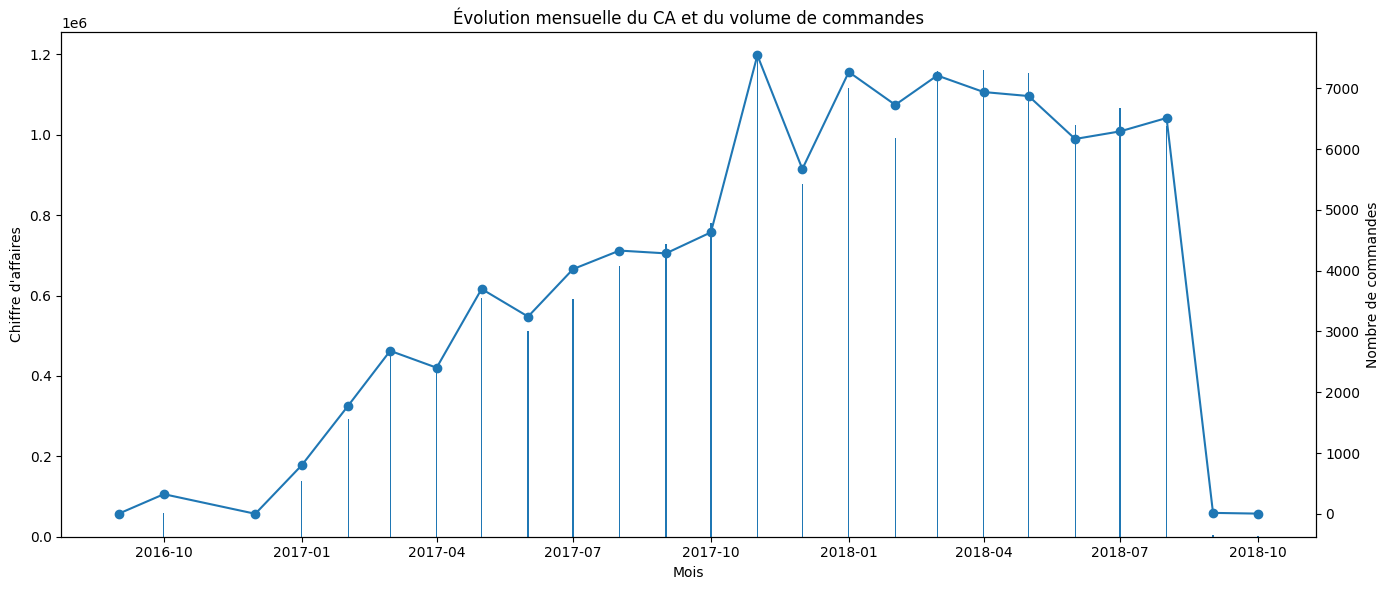

In [50]:
# 1) Évolution mensuelle des ventes et du volume de commandes

# Préparation
monthly = (
    fva
    .groupby("year_month", as_index=False)
    .agg(
        orders_count=("order_id", "nunique"),
        revenue=("value", "sum"),
        avg_score=("score", "mean")
    )
)

# Affichage
print("== 1) Synthèse mensuelle : volume, CA et score moyen ==")
print(monthly.head())

print("\nTop 5 mois par chiffre d'affaires :")
print(monthly.sort_values("revenue", ascending=False).head(5))

print("\nScore moyen global (tous mois confondus) :")
print(monthly["avg_score"].mean())

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.bar(monthly["year_month"], monthly["revenue"])
ax1.set_xlabel("Mois")
ax1.set_ylabel("Chiffre d'affaires")

ax2 = ax1.twinx()
ax2.plot(monthly["year_month"], monthly["orders_count"], marker="o")
ax2.set_ylabel("Nombre de commandes")

plt.title("Évolution mensuelle du CA et du volume de commandes")
plt.tight_layout()
plt.show()


== 2) Score moyen par mois ==
  year_month  avg_score  orders_count
0 2016-09-01   1.000000             4
1 2016-10-01   3.592476           324
2 2016-12-01   5.000000             1
3 2017-01-01   4.106329           800
4 2017-02-01   4.035633          1780

Mois avec les scores moyens les plus faibles :
   year_month  avg_score  orders_count
0  2016-09-01   1.000000             4
23 2018-09-01   1.800000            16
24 2018-10-01   2.250000             4
1  2016-10-01   3.592476           324
17 2018-03-01   3.772943          7211

Mois avec les scores moyens les plus élevés :
   year_month  avg_score  orders_count
2  2016-12-01   5.000000             1
20 2018-06-01   4.282202          6167
21 2018-07-01   4.279334          6292
10 2017-08-01   4.278502          4331
22 2018-08-01   4.257672          6512


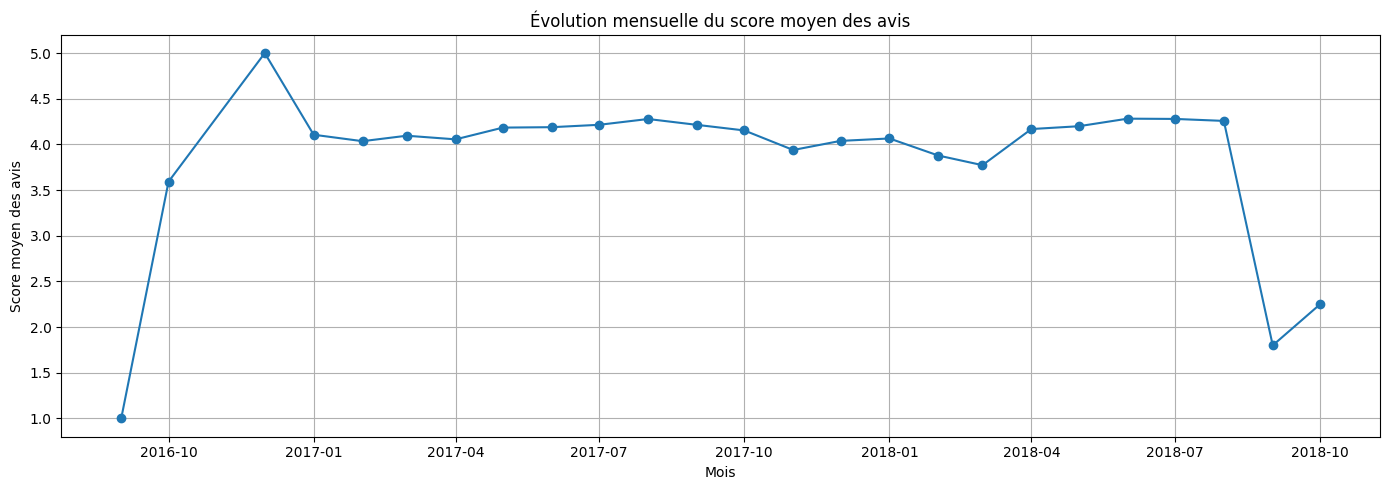

In [51]:
# 2) Évolution mensuelle du score moyen des avis

# Préparation
monthly_score = (
    fva
    .groupby("year_month", as_index=False)
    .agg(
        avg_score=("score", "mean"),
        orders_count=("order_id", "nunique")
    )
)

# Affichage
print("== 2) Score moyen par mois ==")
print(monthly_score.head())

print("\nMois avec les scores moyens les plus faibles :")
print(monthly_score.sort_values("avg_score").head(5))

print("\nMois avec les scores moyens les plus élevés :")
print(monthly_score.sort_values("avg_score", ascending=False).head(5))

plt.figure(figsize=(14, 5))
plt.plot(monthly_score["year_month"], monthly_score["avg_score"], marker="o")
plt.xlabel("Mois")
plt.ylabel("Score moyen des avis")
plt.title("Évolution mensuelle du score moyen des avis")
plt.grid(True)
plt.tight_layout()
plt.show()


== 3) Pivot CA (année x mois) ==
month          1          2           3           4           5           6   \
year                                                                           
2016          NaN        NaN         NaN         NaN         NaN         NaN   
2017    138488.04  291908.01   449863.60   417788.03   592918.82   511276.38   
2018   1115004.18  992463.34  1159652.12  1160785.48  1153982.15  1023880.50   

month          7           8          9          10         11         12  
year                                                                       
2016          NaN         NaN     252.24   59090.48        NaN      19.62  
2017    592382.92   674396.32  727762.45  779677.88  1194882.8  878401.48  
2018   1066540.75  1022425.32    4439.54     589.67        NaN        NaN  

== Pivot score moyen (année x mois) ==
month        1         2         3         4         5         6         7   \
year                                                               

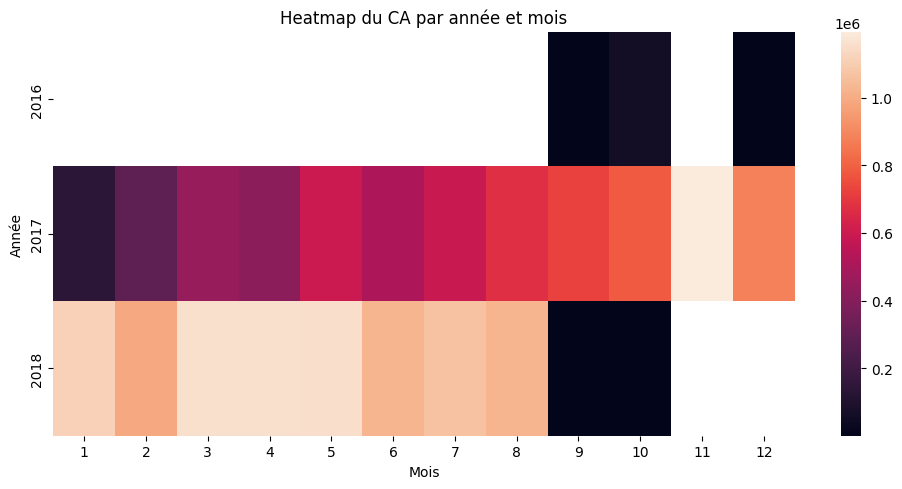

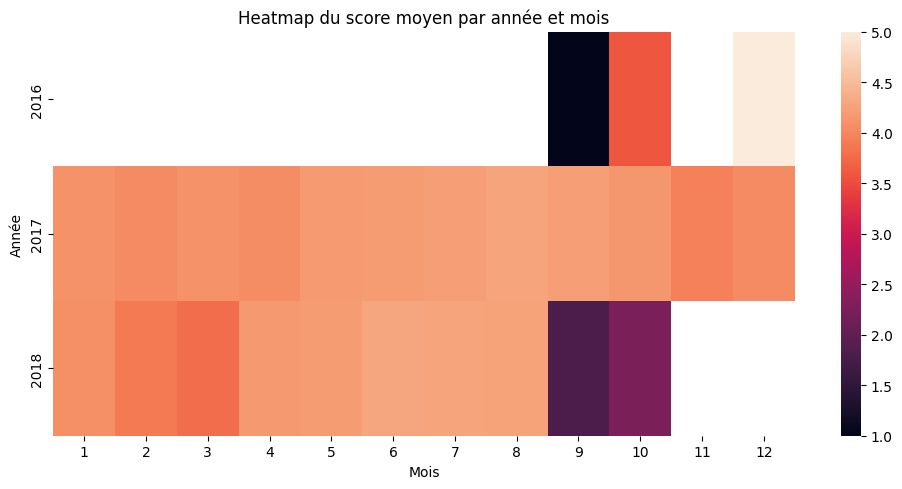

In [52]:
# 3) Heatmaps année x mois : chiffre d'affaires et score moyen

# Préparation
monthly2 = (
    fva
    .groupby(["year", "month"], as_index=False)
    .agg(
        revenue=("value", "sum"),
        avg_score=("score", "mean")
    )
)

pivot_rev = monthly2.pivot(index="year", columns="month", values="revenue")
pivot_score = monthly2.pivot(index="year", columns="month", values="avg_score")

# Affichage
print("== 3) Pivot CA (année x mois) ==")
print(pivot_rev)

print("\n== Pivot score moyen (année x mois) ==")
print(pivot_score)

plt.figure(figsize=(10, 5))
sns.heatmap(pivot_rev, annot=False)
plt.title("Heatmap du CA par année et mois")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.heatmap(pivot_score, annot=False)
plt.title("Heatmap du score moyen par année et mois")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()


== 4) Distribution des scores d'avis ==
    score  orders_count     revenue
0     1.0         11286  2211295.76
1     2.0          3139   541828.52
2     3.0          8085  1227317.14
3     4.0         18964  2939446.92
4     5.0         56739  8880388.22
5     6.0            60     8184.56
6     7.0            25     3591.14
7     8.0            69     8778.43
8     9.0            54     6582.05
9    10.0           250    31445.56
10   13.0             1       42.77
11   15.0             1      204.72

Score moyen global (toutes commandes) :
4.109239609619653


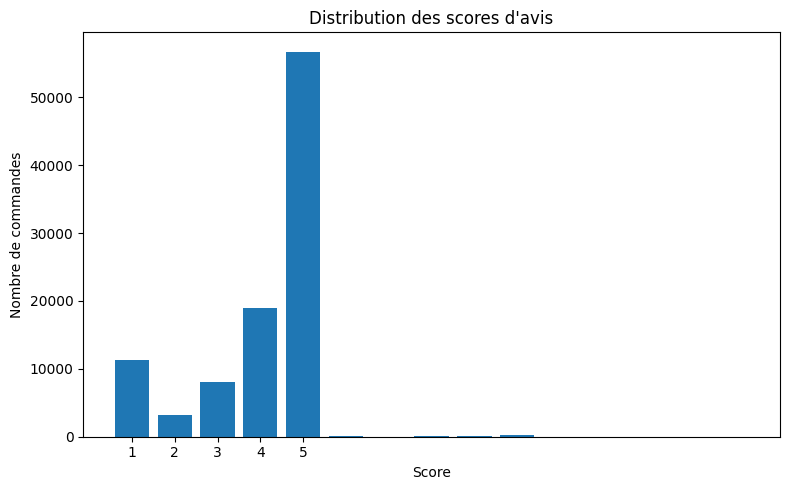

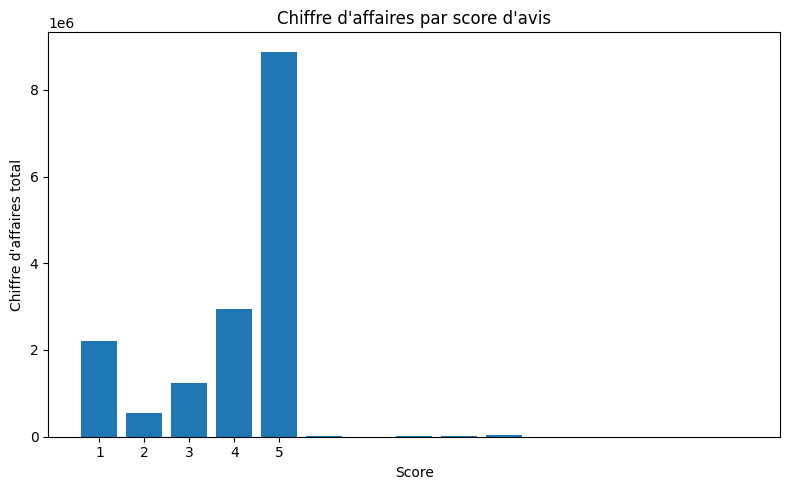

In [53]:
# 4) Distribution globale des scores d'avis

# Préparation
score_dist = (
    fva
    .groupby("score", as_index=False)
    .agg(
        orders_count=("order_id", "nunique"),
        revenue=("value", "sum")
    )
)

# Affichage
print("== 4) Distribution des scores d'avis ==")
print(score_dist)

print("\nScore moyen global (toutes commandes) :")
print(fva["score"].mean())

plt.figure(figsize=(8, 5))
plt.bar(score_dist["score"], score_dist["orders_count"])
plt.xlabel("Score")
plt.ylabel("Nombre de commandes")
plt.title("Distribution des scores d'avis")
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(score_dist["score"], score_dist["revenue"])
plt.xlabel("Score")
plt.ylabel("Chiffre d'affaires total")
plt.title("Chiffre d'affaires par score d'avis")
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()


== 5) Score moyen par classe de délai de livraison ==
  delivery_bucket  orders_count     revenue  avg_score
0            <=1j            13     2188.90   4.230769
1            1-3j          4740   574301.84   4.496398
2            3-7j         21293  2997473.46   4.422830
3           7-14j         40215  6448216.88   4.334775
4            >14j         30215  5399650.35   3.745928


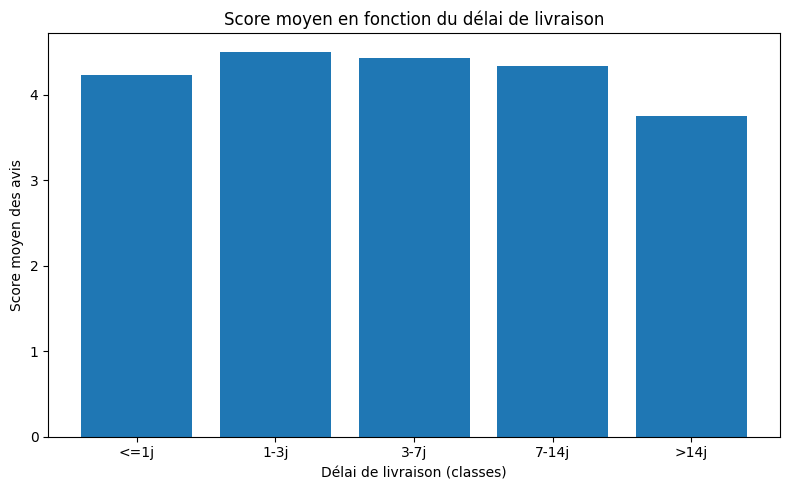

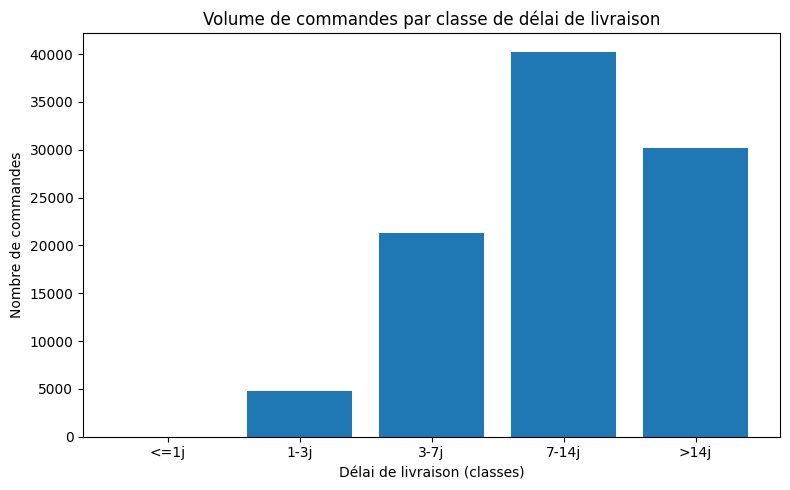

In [54]:
# 5) Score moyen en fonction du délai de livraison (classes de délai)

# Préparation
import numpy as np  # si pas déjà importé plus haut

tmp = fva.copy()
tmp = tmp[tmp["livree"].notna() & (tmp["livree"] > 0)]

# Bornes fixes en heures : 0-24, 24-72, 72-168, 168-336, >336
bins = [0, 24, 72, 168, 336, np.inf]  # dernière borne infinie pour éviter le problème
labels = ["<=1j", "1-3j", "3-7j", "7-14j", ">14j"]

tmp["delivery_bucket"] = pd.cut(
    tmp["livree"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

delivery_score = (
    tmp
    .groupby("delivery_bucket", as_index=False, observed=False)  # ← ajout pour supprimer le FutureWarning
    .agg(
        orders_count=("order_id", "nunique"),
        revenue=("value", "sum"),
        avg_score=("score", "mean")
    )
)

# Affichage
print("== 5) Score moyen par classe de délai de livraison ==")
print(delivery_score.sort_values("delivery_bucket"))

plt.figure(figsize=(8, 5))
plt.bar(delivery_score["delivery_bucket"], delivery_score["avg_score"])
plt.xlabel("Délai de livraison (classes)")
plt.ylabel("Score moyen des avis")
plt.title("Score moyen en fonction du délai de livraison")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(delivery_score["delivery_bucket"], delivery_score["orders_count"])
plt.xlabel("Délai de livraison (classes)")
plt.ylabel("Nombre de commandes")
plt.title("Volume de commandes par classe de délai de livraison")
plt.tight_layout()
plt.show()


== 6) Synthèse par mode de paiement principal ==
  main_payment_type  orders_count      revenue  avg_score
1       credit_card         74935  12535370.24   4.110086
0            boleto         19784   2869361.27   4.112854
4           voucher          3191    386200.82   4.032585
2        debit_card          1527    217939.79   4.187377
3           unknown             4         0.00   1.500000


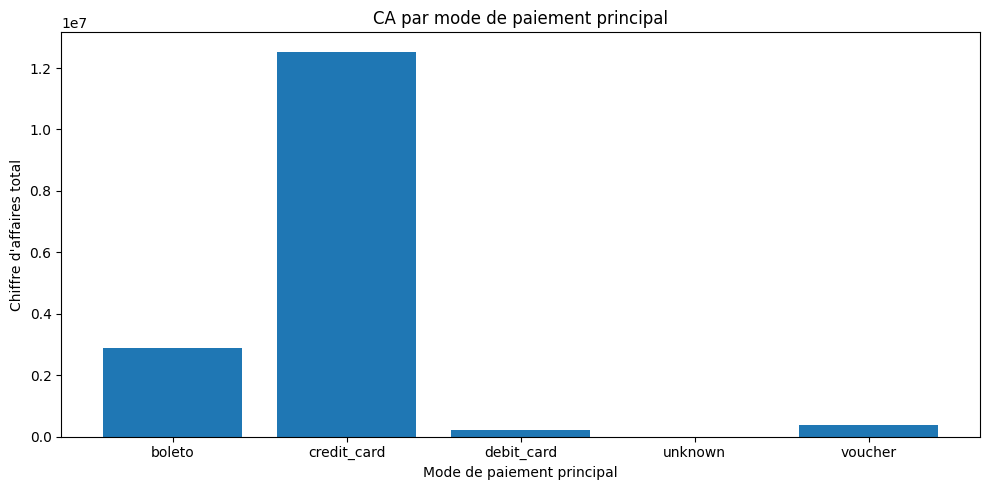

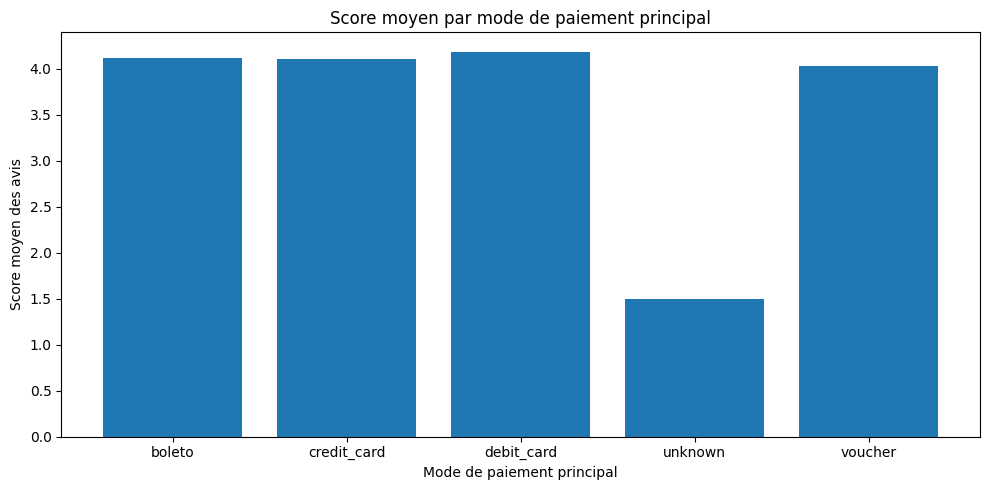

In [55]:
# 6) CA et score moyen par mode de paiement principal

# Préparation
pay_value_cols = [c for c in fva.columns if c.startswith("value_") and c != "value"]

def main_payment_type(row):
    sub = row[pay_value_cols]
    if sub.isna().all() or sub.max() == 0:
        return "unknown"
    return sub.idxmax().replace("value_", "")

fva["main_payment_type"] = fva[pay_value_cols].apply(main_payment_type, axis=1)

pay_agg = (
    fva
    .groupby("main_payment_type", as_index=False)
    .agg(
        orders_count=("order_id", "nunique"),
        revenue=("value", "sum"),
        avg_score=("score", "mean")
    )
)

# Affichage
print("== 6) Synthèse par mode de paiement principal ==")
print(pay_agg.sort_values("revenue", ascending=False))

plt.figure(figsize=(10, 5))
plt.bar(pay_agg["main_payment_type"], pay_agg["revenue"])
plt.xlabel("Mode de paiement principal")
plt.ylabel("Chiffre d'affaires total")
plt.title("CA par mode de paiement principal")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(pay_agg["main_payment_type"], pay_agg["avg_score"])
plt.xlabel("Mode de paiement principal")
plt.ylabel("Score moyen des avis")
plt.title("Score moyen par mode de paiement principal")
plt.tight_layout()
plt.show()
